In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
# plt.style.use('tableau-colorblind10')

from sparse_circuit import quantum_circuit
from sparse_circuit import haar_2qbit, zero_bitstring_np, random_superpos_coo, zero_bitstring_coo, haar_cnot_block
from sparse_circuit import compute_fidelity_multi, save_run_data, load_run_data
from sparse_circuit import *

## Test output distribution with dense circuit

In [2]:
%%time
n_qbits = 18
n_layers = 18
sparse_type=None

zero_constructors = {
    'coo': zero_bitstring_coo,
    None: zero_bitstring_np
}

# construct wires and gates 
wires = np.concatenate([
    construct_random_wire_list(n_qbits) for _ in range(n_layers)
])
# wires_inv = [w for w in reversed(wires)]


# construct gates and their inverses
gates =[haar_2qbit(sparse_type=sparse_type) for _ in wires]
# gates_inv = [invert_sparse_gate(gate) for gate in reversed(gates)]

circuit = quantum_circuit(n_qbits, gates, wires)
output = circuit.contract(zero_constructors[sparse_type](n_qbits))

magnitudes = np.abs(output.flatten())**2
# print(magnitudes.__sizeof__()*1e-9)
# print(magnitudes)

CPU times: user 962 ms, sys: 3.39 ms, total: 965 ms
Wall time: 974 ms


In [3]:
mask = np.zeros_like(magnitudes)
mask[:int(0.1*mask.size)] = 1
np.random.shuffle(mask)
mask.shape = output.shape

output_trimmed = output*mask
output_trimmed /= np.sum(np.abs(expected_output * np.conj(approx_output)))

NameError: name 'expected_output' is not defined

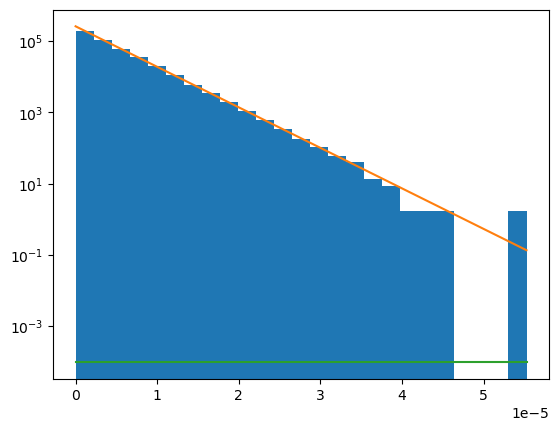

In [4]:
n_bins = 25
factor = 2**n_qbits
# max_idx

n, bins, _ = plt.hist(magnitudes, n_bins, range=(0, magnitudes.max()), density=True)
x = (bins[1:] + bins[:-1])/2
# print(sum(n*x))
# bin_width = bins[1] - bins[0]

plt.plot(bins, factor*np.exp(-1*factor*bins))
plt.plot(bins, 1/factor*np.ones_like(bins)*n_bins)
# plt.xscale('log')
plt.yscale('log')

# x = np.histogram(magnitudes, n_bins)
# for i in x:
#     print(len(i))# print(n, bins)

# fig = plt.stairs(n, bins)

In [ ]:
b = bins[1:] - bins[:-1]
sum(b*n)

## Output distribution with culling

In [123]:
# circuit parameters
n_qbits = 15
n_layers = 15
sparse_type = 'coo'
total_gates = int(n_qbits/2)* n_layers

#run parameters
d = 0.1
n_paths = int(2**n_qbits * d)

# construct gates with their inverses
gates =[haar_2qbit(sparse_type=sparse_type) for _ in range(total_gates)]
gates_inv = [invert_sparse_gate(gate) for gate in reversed(gates)]

# construct wires and gates 
wires = np.concatenate([
    construct_random_wire_list(n_qbits) for _ in range(n_layers)
])
wires_inv = [w for w in reversed(wires)]

gates = [haar_2qbit(sparse_type=sparse_type) for _ in wires]
gates_inv = [invert_sparse_gate(gate) for gate in reversed(gates)]

#create list of functions
fns = [(trim_n_coo(n_paths), 1), (norm_state, 1)]

# define circuit
circuit = quantum_circuit(n_qbits, gates=gates, wires=wires)
# output = circuit.contract(random_superpos_coo(n_qbits, n_paths), fns=fns)
output = circuit.contract(zero_bitstring_coo(n_qbits), fns=fns)


0.0
32768 0.0
[0.00019626 0.00020831 0.00018954 0.00028968 0.00033137 0.00023684
 0.0005615  0.00012557 0.00024992 0.00029556]


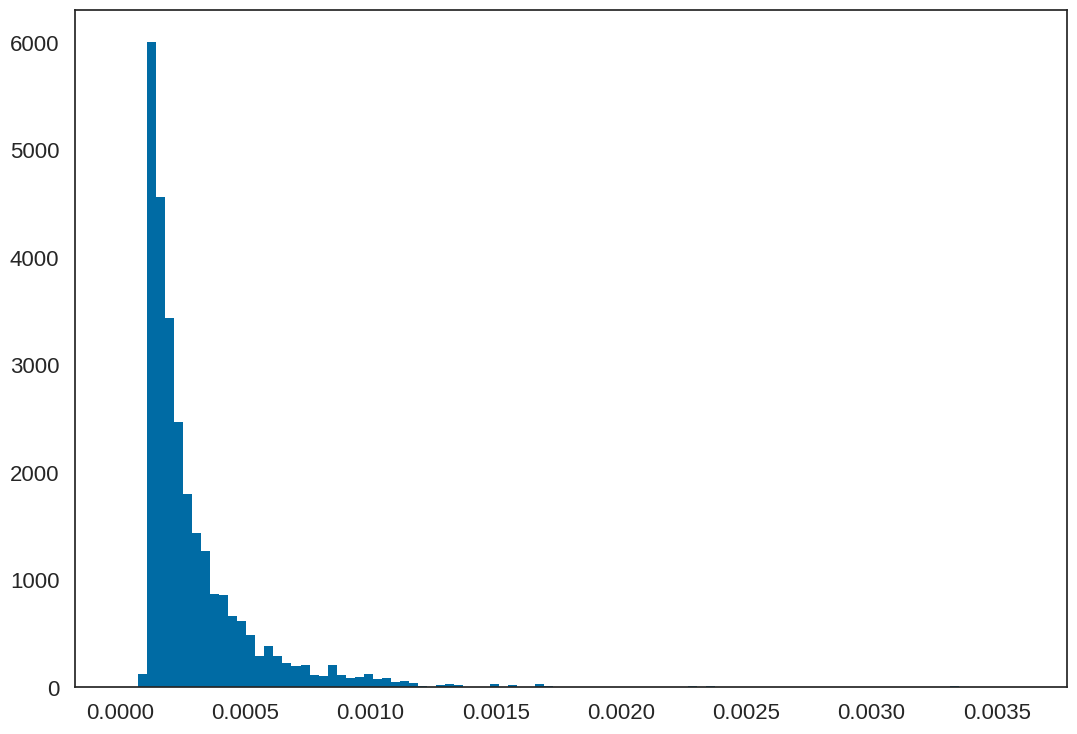

In [127]:
n_bins = 100
factor = 2**n_qbits

magnitudes = np.abs(output.data)**2  

n, bins, _ = plt.hist(magnitudes, n_bins, range=(0, magnitudes.max()), density=True)
x = (bins[1:] + bins[:-1])/2
# print(sum(n*x))
# bin_width = bins[1] - bins[0]
print(bins[0])

# plt.plot(bins, factor*np.exp(-1*factor*bins))
print(factor, n[0])
# plt.yscale('log')
# x = np.histogram(magnitudes, n_bins)
# for i in x:
#     print(len(i))# print(n, bins)

# fig = plt.stairs(n, bins)
print(magnitudes[:10])

# Scaling with Gate count

## 1. 5 layers

In [3]:
# circuit parameters
n_qbits = 12
n_layers = 5
total_gates = (n_qbits-1) * n_layers
sparse_type = 'coo'

#run parameters
min_paths = 100
max_paths = 10000
n_path_vals = 100

D_list = np.linspace(min_paths, min(2**n_qbits, max_paths), n_path_vals, dtype=int)

# construct wires and gates 
wires = np.concatenate([
    construct_random_wire_list(n_qbits) for _ in range(n_layers)
])
wires_inv = [w for w in reversed(wires)]

# construct gates with their inverses
gates =[haar_2qbit(sparse_type=sparse_type) for _ in wires]
gates_inv = [invert_sparse_gate(gate) for gate in reversed(gates)]

#create list of functions
fns_list = [
    [(trim_n_coo(n), 1), (norm_state, 1)]
    for n in D_list
]

# define circuit
circuit = quantum_circuit(n_qbits, gates=gates+gates_inv, wires=np.concatenate([wires, wires_inv]))

# construct input/output states
states = [random_superpos_coo(n_qbits, n) for n in D_list]

# compute_fidelities
fidelities = compute_fidelity_multi(circuit, fns_list, input_state=states, expected_output=states)

# Save to file
save_run_data(f'results_test/12_qbit_{n_layers}.pkl', n_qbits=circuit.n_qbits, n_gates=len(circuit.gates), n_paths=D_list, fidelities=fidelities)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.84it/s]


## 2.) 10 layers

In [4]:
# circuit parameters
n_qbits = 12
n_layers = 10
total_gates = (n_qbits-1) * n_layers
sparse_type = 'coo'

#run parameters
min_paths = 100
max_paths = 10000
n_path_vals = 100

D_list = np.linspace(min_paths, min(2**n_qbits, max_paths), n_path_vals, dtype=int)

# construct wires and gates 
wires = np.concatenate([
    construct_random_wire_list(n_qbits) for _ in range(n_layers)
])
wires_inv = [w for w in reversed(wires)]

# construct gates with their inverses
gates =[haar_2qbit(sparse_type=sparse_type) for _ in wires]
gates_inv = [invert_sparse_gate(gate) for gate in reversed(gates)]

#create list of functions
fns_list = [
    [(trim_n_coo(n), 1), (norm_state, 1)]
    for n in D_list
]

# define circuit
circuit = quantum_circuit(n_qbits, gates=gates+gates_inv, wires=np.concatenate([wires, wires_inv]))

# construct input/output states
states = [random_superpos_coo(n_qbits, n) for n in D_list]

# compute_fidelities
fidelities = compute_fidelity_multi(circuit, fns_list, input_state=states, expected_output=states)

# Save to file
save_run_data(f'results_test/12_qbit_{n_layers}.pkl', n_qbits=circuit.n_qbits, n_gates=len(circuit.gates), n_paths=D_list, fidelities=fidelities)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.95it/s]


## 3.) 20 layers

In [5]:
# circuit parameters
n_qbits = 12
n_layers = 20
total_gates = (n_qbits-1) * n_layers
sparse_type = 'coo'

#run parameters
min_paths = 100
max_paths = 10000
n_path_vals = 100

D_list = np.linspace(min_paths, min(2**n_qbits, max_paths), n_path_vals, dtype=int)

# construct wires and gates 
wires = np.concatenate([
    construct_random_wire_list(n_qbits) for _ in range(n_layers)
])
wires_inv = [w for w in reversed(wires)]

# construct gates with their inverses
gates =[haar_2qbit(sparse_type=sparse_type) for _ in wires]
gates_inv = [invert_sparse_gate(gate) for gate in reversed(gates)]

#create list of functions
fns_list = [
    [(trim_n_coo(n), 1), (norm_state, 1)]
    for n in D_list
]

# define circuit
circuit = quantum_circuit(n_qbits, gates=gates+gates_inv, wires=np.concatenate([wires, wires_inv]))

# construct input/output states
states = [random_superpos_coo(n_qbits, n) for n in D_list]

# compute_fidelities
fidelities = compute_fidelity_multi(circuit, fns_list, input_state=states, expected_output=states)

# Save to file
save_run_data(f'results_test/12_qbit_{n_layers}.pkl', n_qbits=circuit.n_qbits, n_gates=len(circuit.gates), n_paths=D_list, fidelities=fidelities)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.04s/it]


## 4.) 50 Layers

In [6]:
# circuit parameters
n_qbits = 12
n_layers = 50
total_gates = (n_qbits-1) * n_layers
sparse_type = 'coo'

#run parameters
min_paths = 100
max_paths = 10000
n_path_vals = 100

D_list = np.linspace(min_paths, min(2**n_qbits, max_paths), n_path_vals, dtype=int)

# construct wires and gates 
wires = np.concatenate([
    construct_random_wire_list(n_qbits) for _ in range(n_layers)
])
wires_inv = [w for w in reversed(wires)]

# construct gates with their inverses
gates =[haar_2qbit(sparse_type=sparse_type) for _ in wires]
gates_inv = [invert_sparse_gate(gate) for gate in reversed(gates)]

#create list of functions
fns_list = [
    [(trim_n_coo(n), 1), (norm_state, 1)]
    for n in D_list
]

# define circuit
circuit = quantum_circuit(n_qbits, gates=gates+gates_inv, wires=np.concatenate([wires, wires_inv]))

# construct input/output states
states = [random_superpos_coo(n_qbits, n) for n in D_list]

# compute_fidelities
fidelities = compute_fidelity_multi(circuit, fns_list, input_state=states, expected_output=states)

# Save to file
save_run_data(f'results_test/12_qbit_{n_layers}.pkl', n_qbits=circuit.n_qbits, n_gates=len(circuit.gates), n_paths=D_list, fidelities=fidelities)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:16<00:00,  2.56s/it]


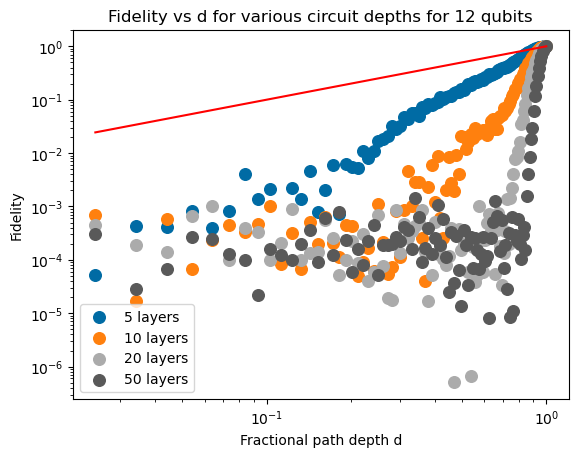

In [7]:
plt.style.use('tableau-colorblind10')
run5_data = load_run_data(f'results_test/12_qbit_5.pkl')
run10_data = load_run_data(f'results_test/12_qbit_10.pkl')
run20_data = load_run_data(f'results_test/12_qbit_20.pkl')
run50_data = load_run_data(f'results_test/12_qbit_50.pkl')

n_paths = run5_data['n_paths']
depth = n_paths/(2**run5_data["n_qbits"])
fidelities = [(data['n_gates']/12, data['fidelities']) for data in [run5_data, run10_data, run20_data, run50_data]]

fig, ax = plt.subplots()

for n, f in fidelities:
    ax.scatter(depth, f, label=f'{int(n)} layers',s=70)
ax.plot(depth, depth, c='red')
ax.legend()
ax.set_xlabel('Fractional path depth d')
ax.set_ylabel('Fidelity')
plt.title('Fidelity vs d for various circuit depths for 12 qubits')

plt.xscale('log')
plt.yscale('log')

# Compare random with "smart" culling

In [2]:
# circuit parameters
n_qbits = 12
n_layers = 20
total_gates = (n_qbits-1) * n_layers
sparse_type = 'coo'

#run parameters
min_paths = 100
max_paths = 10000
n_path_vals = 100

D_list = np.linspace(min_paths, min(2**n_qbits, max_paths), n_path_vals, dtype=int)

# construct wires and gates 
wires = np.concatenate([
    construct_random_wire_list(n_qbits) for _ in range(n_layers)
])
wires_inv = [w for w in reversed(wires)]

# construct gates with their inverses
gates =[haar_2qbit(sparse_type=sparse_type) for _ in wires]
gates_inv = [invert_sparse_gate(gate) for gate in reversed(gates)]

#create list of functions
fns_list = [
    [(trim_n_random_coo(n), 1), (norm_state, 1)]
    for n in D_list
]

# define circuit
circuit = quantum_circuit(n_qbits, gates=gates+gates_inv, wires=np.concatenate([wires, wires_inv]))

# construct input/output states
states = [random_superpos_coo(n_qbits, n) for n in D_list]

# compute_fidelities
fidelities = compute_fidelity_multi(circuit, fns_list, input_state=states, expected_output=states)

# Save to file
save_run_data(f'results_test/12_qbit_{n_layers}_rand.pkl', n_qbits=circuit.n_qbits, n_gates=len(circuit.gates), n_paths=D_list, fidelities=fidelities)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


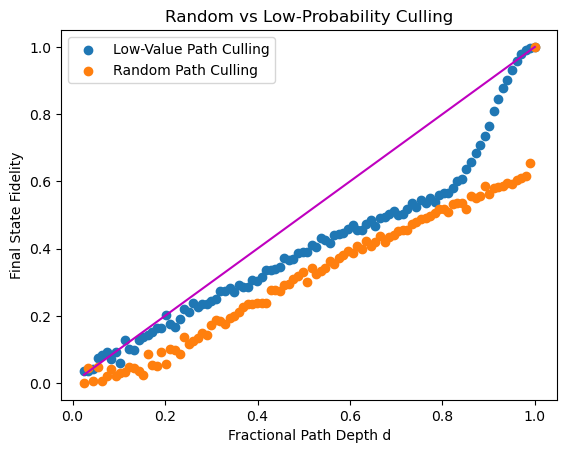

In [18]:
run_data_low = load_run_data(f'results_test/12_qbit_20.pkl')
run_data_rand = load_run_data(f'results_test/12_qbit_20_rand.pkl')

depth = run_data_low['n_paths']/(2**run_data_low["n_qbits"])
fidelity_low = run_data_low['fidelities']
fidelity_rand = run_data_rand['fidelities']

fig, ax = plt.subplots()
ax.scatter(depth, fidelity_low, label='Low-Value Path Culling')
ax.scatter(depth, fidelity_rand, label='Random Path Culling')
ax.plot(depth, depth, c='m')
ax.set_xlabel('Fractional Path Depth d')
ax.set_ylabel('Final State Fidelity')
ax.set_title('Random vs Low-Probability Culling')
ax.legend()

# Culling at the end

In [2]:
# circuit parameters
n_qbits = 15
n_layers = 15
sparse_type = 'coo'

#run parameters
min_paths = 100
max_paths = 2**n_qbits
n_path_vals = 25

D_list = np.linspace(min_paths, min(2**n_qbits, max_paths), n_path_vals, dtype=int)

# construct wires and gates 
wires = np.concatenate([
    construct_random_wire_list(n_qbits) for _ in range(n_layers)
])

# construct gates with their inverses
gates =[haar_2qbit(sparse_type=sparse_type) for _ in wires]
gates_inv = [invert_sparse_gate(gate) for gate in reversed(gates)]

#create list of functions
fns_list = [
    [(trim_n_random_coo(n), len(wires)), (norm_state, len(wires))]
    for n in D_list
]

# define circuit
circuit = quantum_circuit(n_qbits, gates=gates, wires=wires)

# construct input/output states
states = zero_bitstring_coo(n_qbits)

# compute_fidelities
fidelities = compute_fidelity_multi(circuit, fns_list, input_state=states)

# Save to file
save_run_data(f'results_test/12_qbit_{n_layers}_1cull.pkl', n_qbits=circuit.n_qbits, n_gates=len(circuit.gates), n_paths=D_list, fidelities=fidelities)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [02:04<00:00,  4.97s/it]


Text(0.5, 1.0, 'Culling only at the End')

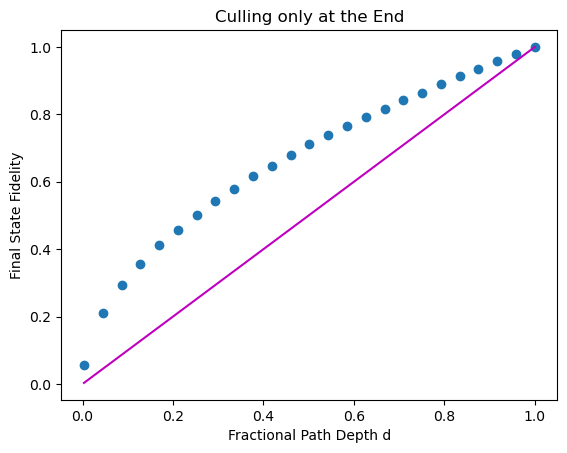

In [4]:
run_data = load_run_data(f'results_test/12_qbit_15_1cull.pkl')

depth = run_data['n_paths']/(2**run_data["n_qbits"])
fidelity = run_data['fidelities']

fig, ax = plt.subplots()
ax.scatter(depth, fidelity, label='Low-Value Path Culling')
ax.plot(depth, depth, c='m')
ax.set_xlabel('Fractional Path Depth d')
ax.set_ylabel('Final State Fidelity')
ax.set_title('Culling only at the End')

In [8]:
x = [0,1,2,3,4]
x.insert(1, 5)
print(x)

[0, 5, 1, 2, 3, 4]


In [13]:
x = [2,1]
sorted(x)
print(x)

[2, 1]
